In [155]:
import yfinance as yf
import pandas as pd

# Lista de símbolos de ações
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'V', 'JPM', 'JNJ',
           'UNH', 'BAC', 'HD', 'PG', 'INTC', 'VZ', 'CSCO', 'PFE', 'KO', 'DIS']

# Data de início e fim para o histórico
start_date = '2000-01-01'
end_date = '2023-11-01'

# Cria um DataFrame vazio para armazenar os dados
historical_data = pd.DataFrame()

# Itera sobre os símbolos das ações e obtém os dados históricos
for symbol in symbols:
    data = yf.download(symbol, start=start_date, end=end_date)
    historical_data[symbol] = data['Adj Close']  # Adiciona uma coluna para o símbolo da ação

historical_data=historical_data.dropna(axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [156]:
hist_infos = historical_data.pct_change().dropna()

In [289]:
def simulacao(ativo,ativo_add,dataframe,size_position = 1):
    # VaR de 5% do ativo:
    var_5 = dataframe[ativo].quantile(.05)
    var_up = dataframe[ativo].quantile(.15)
    var_down = dataframe[ativo].quantile(.001)

    #Filtrando o periodo
    dataframe_5 = dataframe[(dataframe[ativo] >= var_down) &(dataframe[ativo] <= var_up)]
    
    #Covariancia no periodo
    cov_5 = dataframe_5[ativo].cov(dataframe_5[ativo_add])

    #Volatilidade no periodo
    variancia_5 = dataframe_5[ativo].var()

    # Beta estimado dentro do periodo
    beta_5 = cov_5 / variancia_5
    intercepto = dataframe_5[ativo_add].median() - dataframe_5[ativo].median()*beta_5

    # Efeito do ativo segundo o modelo
    var_5_model = (1+beta_5*size_position)*var_5 
    # Efeito real

    var_5_post = (dataframe[ativo]+dataframe[ativo_add]*size_position).quantile(0.05)


    return var_5,var_5_post,var_5_model


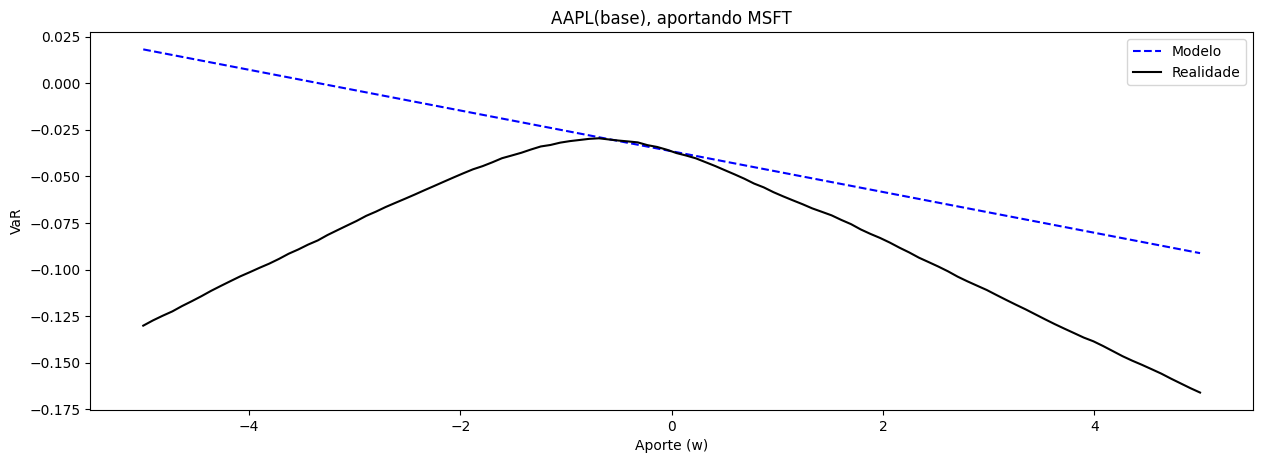

In [298]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5),dpi=100)

modelo = []
realidade = []
linea = np.linspace(-5,5,110)

ativo1 = 'AAPL'
ativo2 = 'MSFT'

for i in linea:
    _,y,y_ = simulacao(ativo1,ativo2,hist_infos,i)

    modelo.append(y_)
    realidade.append(y)


plt.plot(linea, modelo, 'b--', label='Modelo')

plt.plot(linea, realidade, 'black', label='Realidade')

plt.xlabel('Aporte (w)')
plt.ylabel('VaR')

plt.title(f'{ativo1}(base), aportando {ativo2}')

# Adicione uma legenda
plt.legend()

# Exiba o gráfico
plt.show()

In [314]:
def simulacao_limite(ativo,ativo_add,dataframe,size_position = 1):
    # VaR de 5% do ativo:
    var_5 = dataframe[ativo_add].quantile(.05)

    # Efeito do ativo segundo o modelo
    var_5_model = (size_position)*var_5 
    # Efeito real

    var_5_post = (dataframe[ativo]+dataframe[ativo_add]*size_position).quantile(0.05)


    return var_5,var_5_post,var_5_model


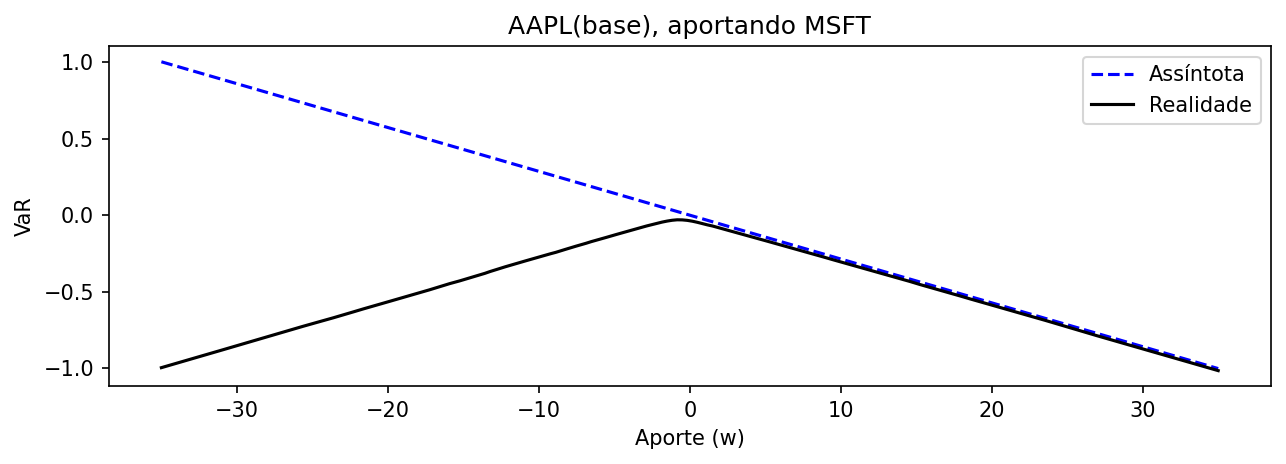

In [320]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3),dpi=150)

modelo = []
realidade = []
linea = np.linspace(-35,35,210)

ativo1 = 'AAPL'
ativo2 = 'MSFT'

for i in linea:
    _,y,y_ = simulacao_limite(ativo1,ativo2,hist_infos,i)

    modelo.append(y_)
    realidade.append(y)


plt.plot(linea, modelo, 'b--', label='Assíntota')

plt.plot(linea, realidade, 'black', label='Realidade')

plt.xlabel('Aporte (w)')
plt.ylabel('VaR')

plt.title(f'{ativo1}(base), aportando {ativo2}')

# Adicione uma legenda
plt.legend()

# Exiba o gráfico
plt.show()

Estimações: [-0.66701775 -0.00427158  0.02590701  0.91654833]


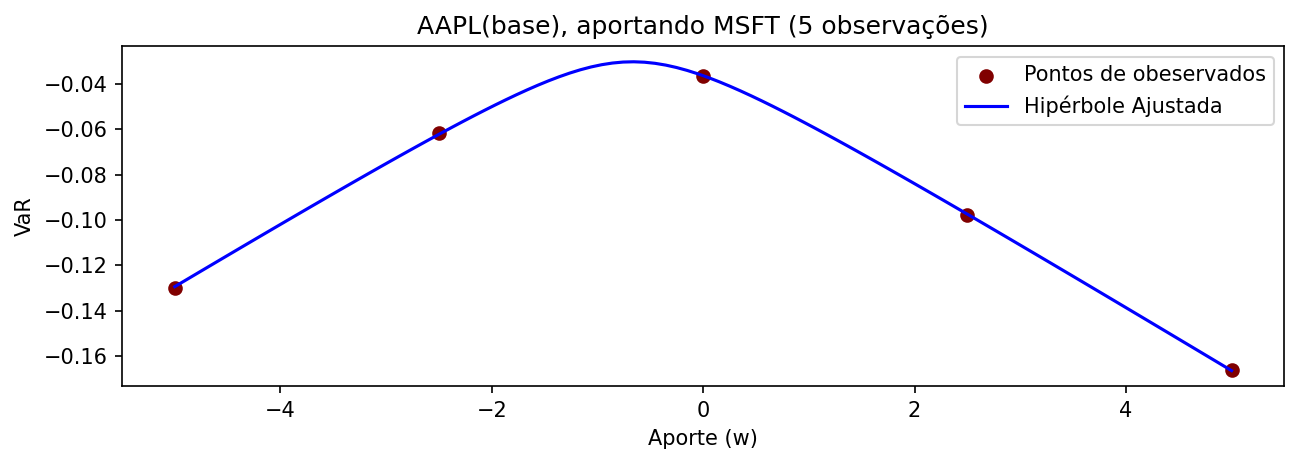

In [391]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10,3),dpi=150)


# Defina a equação da hipérbole com eixos deslocados no formato f(x, a, b, h, k):
def hyperbola(x, h, k, a, b):
    """
    Calcula os valores de y para uma hipérbole rotacionada dada x.

    Parâmetros:
    x : array_like
        Valores de x para os quais calcular y.
    h : float
        A coordenada x do centro da hipérbole.
    k : float
        A coordenada y do centro da hipérbole.
    a : float
        A distância do centro aos vértices.
    b : float
        A distância do centro às diretrizes.
    theta : float
        O ângulo de rotação em radianos.

    Retorna:
    y : ndarray
        Os valores de y correspondentes a x para a hipérbole.
    """
    
    return -a * np.sqrt( 1 +((x-h)/b)**2  ) + k 


realidade = []
linea = np.linspace(-5,5,5)

ativo1 = 'AAPL'
ativo2 = 'MSFT'

for i in linea:
    _,y,y_ = simulacao(ativo1,ativo2,hist_infos,i)

    realidade.append(y)

# Realize o ajuste da curva para encontrar os parâmetros a, b, h e k
params, covariance = curve_fit(hyperbola,linea,realidade, maxfev=50000)

# Parâmetros estimados
a, b, h, k = params

# Gere pontos da curva ajustada
x_fit = np.linspace(-5, 5, 100)
y_fit = hyperbola(x_fit, a, b, h, k)

# Plote os pontos de dados
plt.scatter(linea, realidade, label='Pontos de obeservados', color='maroon')

# Plote a curva ajustada
plt.plot(x_fit, y_fit, label='Hipérbole Ajustada', color='blue')

# Configurações do gráfico
plt.xlabel('Aporte (w)')
plt.ylabel('VaR')
plt.title(f'{ativo1}(base), aportando {ativo2} (5 observações)')
print(f'Estimações: {params}')

plt.legend()

